第一部分的实验是针对噪声的方差，特别是x2的方差。
1：噪声方差作为横坐标
2：训练批次作为横坐标，看不同的方差对损失的影响


第二部分预计变化x3到x16的方差，但是可能m后边要改为2，所以暂时不进行实验

In [2]:
import math
import numpy
import numpy as np
import torch
from torch import nn, optim

M = 2
d = 1024
n_ = 100
dh = 512
dv = 512

class TF(nn.Module):
    def __init__(self):
        super().__init__()
        self.q = nn.Linear(d, dh, bias=False)
        self.k = nn.Linear(d, dh, bias=False)
        self.v = nn.Linear(d, dv, bias=False)
        self.fc = nn.Linear(dv, 1, bias=False)
        self.fc.requires_grad_(False)
        self.q.weight.data /= 16
        self.k.weight.data /= 16
        self.v.weight.data /= 16


    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        qk = torch.matmul(q, k.transpose(1, 2))
        attn = qk.softmax(dim=2)
        attn = torch.sum(attn, dim=1).unsqueeze(1)
        attn /= M
        z = torch.matmul(attn, v).squeeze(1)
        return self.fc(z)

def make_mu1(mu):
    mu1 = numpy.zeros(d)
    mu1[0] = mu
    return mu1

def make_mu2(mu):
    mu2 = numpy.zeros(d)
    mu2[1] = mu
    return mu2

def make_noise(strength):
    return numpy.random.normal(0, strength, size=d)


def Get_test_loss(n, mu,cp):
    D = []
    D_Y = []
    D_ = []
    D_Y_ = []

    mu1 = make_mu1(mu)
    mu2 = make_mu2(mu)

    D_mu = []
    D_mu_ = []

    for i in range(int(n / 2)):
        X = mu1.copy().reshape(1, d)
        X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        for j in range(M - 2):
            X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        D.append(X)
        D_Y.append([1.])
        D_mu.append(mu1.reshape(1, d))
        X = mu2.copy().reshape(1, d)
        X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        for j in range(M - 2):
            X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        D.append(X)
        D_Y.append([-1.])
        D_mu.append(mu2.reshape(1, d))

    D = torch.tensor(D, dtype=torch.float32).cuda()
    D_Y = torch.tensor(D_Y).cuda()

    for i in range(int(n_ / 2)):
        X = mu1.copy().reshape(1, d)
        X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        for j in range(M - 2):
            X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        D_.append(X)
        D_Y_.append([1.])
        D_mu_.append(mu1.reshape(1, d))
        X = mu2.copy().reshape(1, d)
        X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        for j in range(M - 2):
            X = numpy.concatenate((X, (make_noise(cp)).reshape(1, d)), 0)
        D_.append(X)
        D_Y_.append([-1.])
        D_mu_.append(mu2.reshape(1, d))

    D_ = torch.tensor(D_, dtype=torch.float32).cuda()
    D_Y_ = torch.tensor(D_Y_).cuda()

    model = TF().cuda()

    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0)
    loss_fn = nn.SoftMarginLoss().cuda()
    EPOCHS = 1000

    test_losses = []
    for epoch in range(1, EPOCHS + 1):
        model.train()
        optimizer.zero_grad()
        output = model(D)

        training_loss = loss_fn(output, D_Y)
        training_loss.backward()
        optimizer.step()

        model.eval()
        output = model(D_)
        test_loss = loss_fn(output, D_Y_)
        # return test_loss
        if epoch%10 == 0:
            test_losses.append(test_loss.item())

    return test_losses  
        
        
size = 20
n_scale = 2
mu_scale = 1

# 噪声强度（方差）作为横坐标
# matrix = np.zeros((size, 100))
# for n in range(size):
#     print(n)
#     for mu in range(100):
#         matrix[n, mu] = get_test_loss(100, 36, (mu+1)*0.1)
# np.savetxt('噪声方差.npy', matrix)

# 迭代次数作为横坐标，探究不同的噪声方差对损失的影响
matrix1 = np.zeros((20, 100))
for n in range(20):
    print(n)
    test_losses = Get_test_loss(100, 16, 0.5)
    matrix1[n, :] = test_losses
np.savetxt('0.5_.npy', matrix1)
                                      
matrix2 = np.zeros((20, 100))
for n in range(20):
    print(n)
    test_losses = Get_test_loss(100, 16,4)
    matrix2[n, :] = test_losses
np.savetxt('4_.npy', matrix2)

matrix3 = np.zeros((20, 100))
for n in range(20):
    print(n)
    test_losses = Get_test_loss(100, 16, 16)
    matrix3[n, :] = test_losses
np.savetxt('16_.npy', matrix3)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


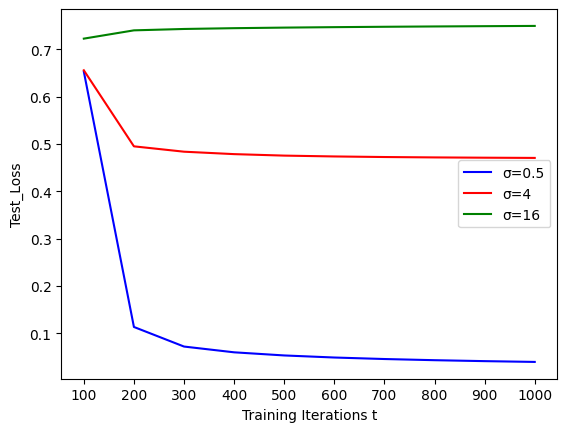

In [1]:
# x2的变化方差
import numpy as np
import matplotlib.pyplot as plt

# 加载npy文件中的矩阵
matrix1 = np.loadtxt('0.5.npy')
matrix2 = np.loadtxt('4.npy')
matrix3 = np.loadtxt('16.npy')


# 计算每个矩阵列方向的平均值
mean_matrix1 = np.mean(matrix1, axis=0)
mean_matrix2 = np.mean(matrix2, axis=0)
mean_matrix3 = np.mean(matrix3, axis=0)


# 假设要均匀抽出10条数据
num_samples = 10
sample_indices = np.linspace(0, len(mean_matrix1) - 1, num_samples, dtype=int)

# 抽取数据
sampled_matrix1 = mean_matrix1[sample_indices]
sampled_matrix2 = mean_matrix2[sample_indices]
sampled_matrix3 = mean_matrix3[sample_indices]


# 生成x轴数据
x = np.arange(num_samples)

# 绘制折线图
plt.plot(x, sampled_matrix1, label='σ=0.5', color='blue')
plt.plot(x, sampled_matrix2, label='σ=4', color='red')
plt.plot(x, sampled_matrix3, label='σ=16', color='green')


# 添加图例
plt.legend()

# 添加标题和坐标轴标签


plt.xlabel('Training Iterations t')
plt.ylabel('Test_Loss')
plt.xticks(x,[100,200,300,400,500,600,700,800,900,1000])
# 显示折线图
plt.savefig('sigma.png', dpi=300, bbox_inches='tight')
plt.show()




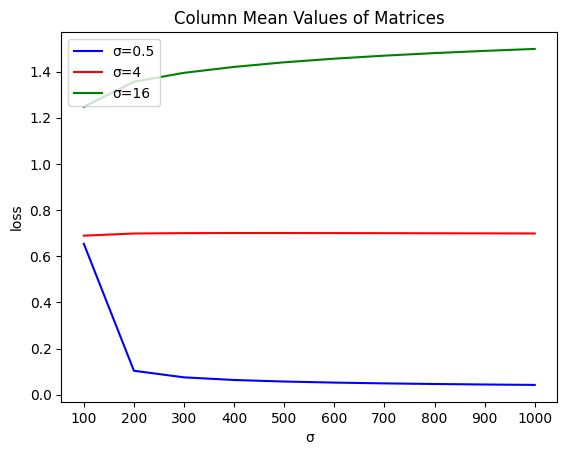

<Figure size 640x480 with 0 Axes>

In [7]:
# x3到x16
import numpy as np
import matplotlib.pyplot as plt

# 加载npy文件中的矩阵
matrix1 = np.loadtxt('0.5_.npy')
matrix2 = np.loadtxt('4_.npy')
matrix3 = np.loadtxt('16_.npy')


# 计算每个矩阵列方向的平均值
mean_matrix1 = np.mean(matrix1, axis=0)
mean_matrix2 = np.mean(matrix2, axis=0)
mean_matrix3 = np.mean(matrix3, axis=0)


# 假设要均匀抽出10条数据
num_samples = 10
sample_indices = np.linspace(0, len(mean_matrix1) - 1, num_samples, dtype=int)

# 抽取数据
sampled_matrix1 = mean_matrix1[sample_indices]
sampled_matrix2 = mean_matrix2[sample_indices]
sampled_matrix3 = mean_matrix3[sample_indices]


# 生成x轴数据
x = np.arange(num_samples)

# 绘制折线图
plt.plot(x, sampled_matrix1, label='σ=0.5', color='blue')
plt.plot(x, sampled_matrix2, label='σ=4', color='red')
plt.plot(x, sampled_matrix3, label='σ=16', color='green')


# 添加图例
plt.legend()

# 添加标题和坐标轴标签

plt.title('Column Mean Values of Matrices')
plt.xlabel('σ')
plt.ylabel('loss')
plt.xticks(x,[100,200,300,400,500,600,700,800,900,1000])
# 显示折线图
plt.show()

plt.savefig('不同噪声方差对损失的影响.png', dpi=1200, bbox_inches='tight')
